In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


In [2]:
train_data = datasets.FashionMNIST(root="datasets",train=True,transform=ToTensor(),download=True)

test_data = datasets.FashionMNIST(root="datasets",train=False,transform=ToTensor(),download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11153862.38it/s]


Extracting datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210698.20it/s]


Extracting datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 828038.13it/s] 


Extracting datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19647203.81it/s]

Extracting datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



In [4]:
type(train_data)

torchvision.datasets.mnist.FashionMNIST

Image shape: torch.Size([1, 28, 28])


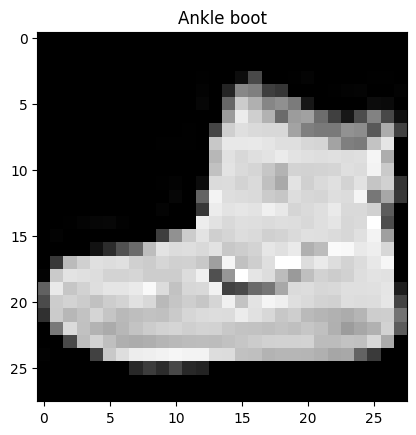

In [ ]:
class_names = train_data.classes

image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

In [ ]:
#Use dataloader

from torch.utils.data import DataLoader
Batch_Size = 32

train_dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle=True )
test_dataloader = DataLoader(test_data, batch_size = Batch_Size, shuffle=True )

In [1]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float):
    total_time = end - start
    print(f"Train time: {total_time:.3f} seconds")
    return total_time

In [ ]:
def trainingLoop(epochs,model,loss_fn,optimizer,accuracy_fn):
  for epoch in range(epochs):

    print(f"Epoch: {epoch}\n-------")

    train_loss = 0
    for batch, (X,y) in enumerate(train_dataloader):
      X.to(device)
      y.to(device)

      model.train()

      y_train_preds = model(X)

      loss = loss_fn(y_train_preds,y)
      train_loss = train_loss + loss

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss = train_loss / len(train_dataloader)

    testingLoop(model,loss_fn,accuracy_fn,optimizer,train_loss)



def testingLoop(model,loss_fn,accuracy_fn,optimizer,train_loss):
    test_loss = 0
    test_accuracy = 0

    model.eval()
    with torch.inference_mode():
      for batch, (X,y) in enumerate(test_dataloader):
        X.to(device)
        y.to(device)

        y_test_logits = model(X)
        y_test_probabilities = torch.softmax(y_test_logits,dim=1)#Converting to probabilities
        y_test_preds = torch.argmax(y_test_probabilities,dim=1)



        loss = loss_fn(y_test_logits,y)
        test_loss = loss +test_loss

        accuracy = accuracy_fn(y_true = y, y_pred = y_test_preds)
        test_accuracy = test_accuracy + accuracy

      test_loss /= len(test_dataloader)
      test_accuracy /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%\n")

In [ ]:
#Building a base model

class BaseModel(nn.Module):
  def __init__(self,INPUT_SIZE : int,HIDDEN_UNITS:int,OUTPUT_SIZE:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_UNITS),
        nn.Linear(in_features=HIDDEN_UNITS,out_features=OUTPUT_SIZE)
    )

  def forward(self,x):
    return self.layer_stack(x)

In [ ]:
model_0 = BaseModel(784,10,len(class_names))
model_0.to(device)

loss_function = nn.CrossEntropyLoss()
from sklearn.metrics import accuracy_score
optimizer=torch.optim.SGD(params = model_0.parameters(),lr=0.05)

train_time_start_on_cpu = timer()

trainingLoop(2,model_0,loss_fn = loss_function, accuracy_fn=accuracy_score,optimizer=optimizer)

train_time_end_on_cpu = timer()

total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu)

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.61536 | Test loss: 0.50687, Test acc: 0.82%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47377 | Test loss: 0.48526, Test acc: 0.83%

Train time: 18.891 seconds


In [ ]:
#Building a CNN model
#Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer

class ConvolutionalNNModel(nn.Module):
  def __init__(self,INPUT_SHAPE : int,HIDDEN_UNITS : int,OUTPUT_SHAPE : int):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels =INPUT_SHAPE, out_channels =HIDDEN_UNITS, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels =HIDDEN_UNITS, out_channels =HIDDEN_UNITS, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=HIDDEN_UNITS*7*7, out_features=OUTPUT_SHAPE)
    )

  def forward(self, x: torch.Tensor):
      x = self.block1(x)
      # print(x.shape)
      x = self.block2(x)
      # print(x.shape)
      x = self.classifier(x)
      # print(x.shape)
      return x

In [ ]:
model_1 = ConvolutionalNNModel(INPUT_SHAPE=1,HIDDEN_UNITS=10,OUTPUT_SHAPE=len(class_names))
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

train_time_start_on_cpu_model = timer()

trainingLoop(2,model_1,loss_fn = loss_function, accuracy_fn=accuracy_score,optimizer=optimizer)

train_time_end_on_cpu = timer()

total_train_time_model_1 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu)

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.57134 | Test loss: 0.39461, Test acc: 0.86%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.34414 | Test loss: 0.34834, Test acc: 0.88%

Train time: 179.582 seconds
